# Emerging Technologies Project
## Cathal Butler | G00346889    
### References
* https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/index.html?index=..%2F..index#0
* https://www.tensorflow.org/guide/data_performance
* https://codelabs.developers.google.com/codelabs/keras-flowers-data/#3
* https://keras.io/examples/mnist_cnn/
* https://www.ics.uci.edu/~mohamadt/keras_mnist.html
* https://machinelearningmastery.com/save-load-keras-deep-learning-models/
* https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc
* https://www.programcreek.com/python/example/89044/keras.utils.np_utils.to_categorical

In [1]:
import matplotlib.pyplot as plt
from keras.utils import np_utils
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


# The number of training examples in one forward/backward pass. 
# The higher the batch size, the more memory space you'll need.
batch_size = 128
num_classes = 10
# Setting the number of forward passes and backward passes of all the training examples
epochs = 10
# input image dimensions : IMPORTANT
img_rows, img_cols = 28, 28

Using TensorFlow backend.


## Load Data set

In [2]:
# Load data. The data, split between train and test sets
# The MINST dataset is loaded from keras:
# TRAIN & TEST
(x_train, y_train), (X_test, y_test) = mnist.load_data()
# Print the original X & Y train shape:
print("Original X shape", x_train.shape)
print("Original Y shape", y_train.shape)

# Reshape data.
if K.image_data_format() == 'channels_first':
    # resizing the train data and storing it inside a NumPy Array:
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    # resizing the test data and storing it inside a NumPy Array:
    x_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    # Define the input shapes for the keras model of the images
    input_shape = (1, img_rows, img_cols)
else:
    # resizing the train data and storing it inside a NumPy Array:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    # resizing the test data and storing it inside a NumPy Array:
    x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    # Define the input shapes for the keras model of the images
    input_shape = (img_rows, img_cols, 1)

# It is common to use 32-bit when training a neural network, regarding the division by 255, this is the max value of a 
# type(the inputs type before conversion to float32), so this will ensure that the inputs are scaled between 0.0 & 1.0.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255 

# Print the training and testing X matrix shape
print("Training X matrix shape", x_train.shape)
print("Testing X matrix shape", X_test.shape)
print (y_train[0])    
    
# Represent the targets as one-hot vectors: e.g. 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0].
nb_classes = 10

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes )
# Printing out the Y training and testing matrix shape
print("Training Y matrix shape", y_train.shape)
print("Testing Y matrix shape", y_test.shape)

Original X shape (60000, 28, 28)
Original Y shape (60000,)
Training X matrix shape (60000, 28, 28, 1)
Testing X matrix shape (10000, 28, 28)
5
Training Y matrix shape (60000, 10)
Testing Y matrix shape (10000, 10)


## Example Data

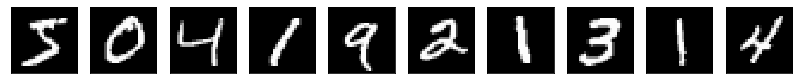

In [3]:
# Plot examples of the data.
plt.figure(1, figsize=(14,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    

## Keras Model
More information on Keras Sequential Models [here](https://keras.io/getting-started/sequential-model-guide/)

* Convolution Layer: This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
    
    * Activation functions:
        * Relu(Rectified Linear Unit):
            
           Relu would typically be used for all layers but the last. For the last layer softmax activation could be used.
           
        * SoftMax:
            
            Softmax is used on the last layer and has an set amount of classes. It should output 10 numbers 
            between 0 and 1 representing the probability of this digit being a 0, a 1, a 2 and so on.
          

In [4]:
# Keras Model
model = Sequential()
# Convolution Layer:
# Input images with 3 channels:
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Unflattened data
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

## Keras Model Summary

In [5]:
# Keras Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

## Compile the Keras Model
Compile the model to build each layer. The loss function is one of the two paramters required to compile the model. 
The second paramter is the optimizer, it is the algorithm used to update the weights.

In [6]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

## Train the model
Train the model and save the history. This will be used to plot the loss trajectory graph below. 

In [7]:
# Training the model
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
# Save the scores
score = model.evaluate(x_test, y_test, verbose=0)
# Display the test loss and test accuracy:
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 37s 625us/step - loss: 0.2465 - accuracy: 0.9235 - val_loss: 0.0632 - val_accuracy: 0.9794
Epoch 2/10
60000/60000 [==============================] - 41s 675us/step - loss: 0.0809 - accuracy: 0.9753 - val_loss: 0.0396 - val_accuracy: 0.9869
Epoch 3/10
60000/60000 [==============================] - 38s 629us/step - loss: 0.0613 - accuracy: 0.9814 - val_loss: 0.0363 - val_accuracy: 0.9880
Epoch 4/10
60000/60000 [==============================] - 35s 580us/step - loss: 0.0500 - accuracy: 0.9844 - val_loss: 0.0323 - val_accuracy: 0.9887
Epoch 5/10
60000/60000 [==============================] - 34s 559us/step - loss: 0.0428 - accuracy: 0.9873 - val_loss: 0.0266 - val_accuracy: 0.9906
Epoch 6/10
60000/60000 [==============================] - 42s 704us/step - loss: 0.0392 - accuracy: 0.9879 - val_loss: 0.0252 - val_accuracy: 0.9913
Epoch 7/10
60000/60000 [==============================]

## Graph loss trajectory throughout training

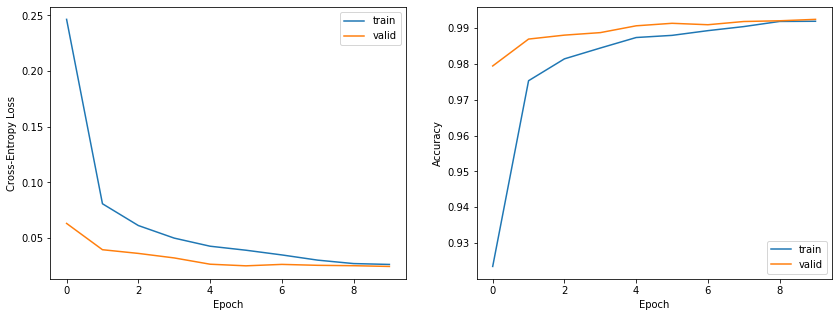

In [8]:
# Plot loss trajectory throughout training.
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## Performance Evaluation

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %.2f%%' % (score[1]*100))

Test cross-entropy loss: 0.02460
Test accuracy: 99.24%


## Save model Weights and Architecture Together
Saving the model this way includes everything about the model 
* Model weights
* Model architecture
* Model compilation details, the loss and metrics
* Model optimizer

In [10]:
# Save the model in h5 format 
model.save("model.h5")
print("Saved model to disk")